In [1]:
import pandas as pd
from pathlib import Path
from IPython.display import display
from pprint import pprint
from src.modules.utils.camera import project_to_camera
from scipy.spatial.transform import Rotation as R
import numpy as np
import cv2

In [2]:
frame_index = 30000

In [3]:
path = Path('/root/data/raw/drive_and_act/iccv_openpose_3d/openpose_3d/vp1')

In [4]:
# !ls '/root/data/raw/drive_and_act/iccv_openpose_3d/openpose_3d/vp1'

In [5]:
# !ls '/root/data/raw/drive_and_act/a_column_co_driver/vp1'

In [6]:
# !head '/root/data/raw/drive_and_act/a_column_co_driver/vp1/run2_2018-05-29-14-33-44.ids_2.calibration.json'

In [7]:
df = pd.read_csv(path / 'run2_2018-05-29-14-33-44.ids_1.openpose.3d.csv')

In [8]:
# df.iloc[frame_index].values

In [9]:
keypoints = [
    "nose",
    "left_eye",
    "right_eye",
    "left_ear",
    "right_ear",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
]
keypoints = []

In [10]:
l = df.columns[2:].map(lambda a: a.split('_')[0])
keypoint_name = []
prev_name = None
for name in l:
    if name != prev_name:
        keypoint_name.append(name)
        prev_name = name

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pose_3d = pd.DataFrame(
        df.iloc[frame_index][df.columns[2:]].to_numpy().reshape([-1, 4]),
        index=keypoint_name, columns=['x', 'y', 'z', 'p']
    )

In [12]:
import json

with (Path('/root/data/raw/drive_and_act/a_column_co_driver/vp1/run2_2018-05-29-14-33-44.ids_2.calibration.json')).open() as f:
    text = f.read()
    obj = json.loads(text)
pprint(obj)

{'extrinsics': {'rotation': {'w': -0.6491170188925511,
                             'x': 0.13323400387777573,
                             'y': 0.29559600860332197,
                             'z': 0.6881270200279371},
                'translation': {'x': -0.050313663745686354,
                                'y': -0.46438405679681816,
                                'z': 0.33412852685454614}},
 'intrinsics': {'distortion': {'k1': -0.2661,
                               'k2': 0.0549,
                               'k3': 0.0,
                               'p1': 0.0,
                               'p2': 0.0},
                'focallength': {'fx': 567.0, 'fy': 567.0},
                'img_size': {'height': 1024, 'width': 1280},
                'principal_point': {'cx': 640.0, 'cy': 512.0}}}


In [13]:
pose_3d_valid = pose_3d[pose_3d.x != 0]

In [14]:
P = pose_3d_valid.values[:,:3]
extrinsics = obj['extrinsics']
intrinsics = obj['intrinsics']
quarternion = extrinsics['rotation']
R = R.from_quat([
    quarternion['w'],
    quarternion['x'],
    quarternion['y'],
    quarternion['z']
]).as_matrix()
T = np.array([
    extrinsics['translation']['x'],
    extrinsics['translation']['y'],
    extrinsics['translation']['z'],
]).reshape([-1, 1])
f = np.array([
    intrinsics['focallength']['fx'],
    intrinsics['focallength']['fy'],
]).reshape([-1, 1])
c = np.array([
    intrinsics['principal_point']['cx'],
    intrinsics['principal_point']['cy'],
]).reshape([-1, 1])
k = np.array([
    intrinsics['distortion']['k1'],
    intrinsics['distortion']['k2'],
    intrinsics['distortion']['k3'],
]).reshape([-1, 1])
p = np.array([
    intrinsics['distortion']['p1'],
    intrinsics['distortion']['p2'],
]).reshape([-1, 1])

In [15]:
projected_2d_matrix, d, radial, tan, r2 = project_to_camera(P, R, T, f, c, k, p)

In [16]:
projected_2d_matrix

array([[ 579.73726105,  291.18486506],
       [ 605.44229953,  163.86100595],
       [ 738.04230655,  259.85651237],
       [ 940.29993612,  187.69890449],
       [ 693.71062363,   34.73414939],
       [ 911.41728841,  320.98157363],
       [ 777.06015089,  157.47721429],
       [ 511.76100567,  286.10258482],
       [ 858.99746047,  161.21388591],
       [1016.59909141,  242.08076945],
       [ 906.3251117 ,   44.3797303 ],
       [ 560.51993395,   85.18610801],
       [ 574.7710942 ,  283.18257034],
       [ 586.93551392,  104.94055936]])

In [17]:
# df.columns.tolist()

In [18]:
# Path('/root/data/raw/drive_and_act/a_column_co_driver/vp1/run2_2018-05-29-14-33-44.ids_2.calibration.json')
video_path = '/root/data/raw/drive_and_act/a_column_co_driver/vp1/run2_2018-05-29-14-33-44.ids_2.mp4'

In [19]:
cap = cv2.VideoCapture(video_path)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [20]:
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
ret, frame = cap.read()
# cv2.imwrite("path_where_to_save_image", frame)

In [21]:
import matplotlib.pyplot as plt

In [22]:
amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
amount_of_frames

42427.0

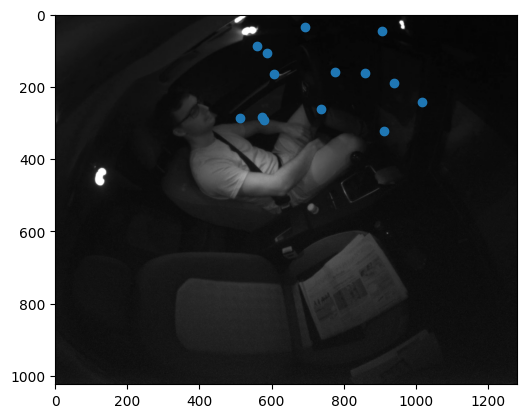

In [23]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

keypoints = pd.DataFrame(projected_2d_matrix, columns=['x', 'y'])

# img = mpimg.imread(img_path)
imgplot = plt.imshow(frame)
plt.scatter(keypoints['x'], keypoints['y'])
plt.show()

In [25]:
!ls

Dockerfile  demo	      saved_lifter_2d_3d_model
Makefile    mmengine_workdir  src
README.md   requirements.txt  test_config.py


In [26]:
cv2.imwrite('./tmp_img/drive_and_act.jpg', frame)

True